<a href="https://colab.research.google.com/github/prime1417/Analysis_Project_Ddareungi/blob/main/Ddareungi_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024년 1월 날씨와 따릉이 데이터 결합

In [ ]:
import pandas as pd

# 2024년 1월 일별 날씨 데이터
weather = pd.read_csv('weather.csv', parse_dates=['일시'])
weather_01 = weather.query('일시 >= "2024-01-01" and 일시 < "2024-02-01"')

# 2024년 1월 일별 총 이용 건수
ddareungi01 = pd.read_csv("ddareungi01.csv", encoding='utf-8', parse_dates=['기준_날짜'])
use_ddareungi01 = ddareungi01.groupby(['기준_날짜'], as_index=False)['전체_건수'].sum()
use_ddareungi01.rename(columns={'기준_날짜':'일시', '전체_건수':'이용건수'}, inplace=True)


# 날씨와 따릉이 데이터
total_data = pd.merge(use_ddareungi01, weather_01, on='일시', how='inner')
total_data.info()
total_data.head()

total_data.to_csv('total_data01.csv', encoding='utf-8', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   일시             31 non-null     datetime64[ns]
 1   이용건수           31 non-null     int64         
 2   지점번호           31 non-null     int64         
 3   지점명            31 non-null     object        
 4   평균기온(℃)        31 non-null     float64       
 5   최고기온(℃)        31 non-null     float64       
 6   최고기온시각         31 non-null     object        
 7   최저기온(℃)        31 non-null     float64       
 8   최저기온시각         31 non-null     object        
 9   평균습도(%rh)      31 non-null     float64       
 10  최저습도(%rh)      31 non-null     int64         
 11  평균풍속(m/s)      31 non-null     float64       
 12  최대풍속(m/s)      31 non-null     float64       
 13  최대풍속풍향(deg)    31 non-null     float64       
 14  최대풍속시각         31 non-null     object        
 15  최대순간풍속(m/s)    31 non-nul

## 2024년 1월 total_data 분석

 - 1월 요일별 따릉이사용횟수 분석

In [215]:
import datetime as dt
## 시간의 범주화를 위한 함수
def func(i) :
  #### 서울 출근 시간대 오전 7시 ~ 10시
  #### 서울 퇴근 시간대 오후 6시 ~ 9시
  if (dt.time(7,0,0)<= i < dt.time(10,0,0)) :
    return '출근대'
  elif (dt.time(18,0,0)<= i < dt.time(21,0,0)) :
    return '퇴근대'
  else :
    return '그 외'

/tmp/ipython-input-2141119959.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.query('집계_기준 == "도착시간"')['기준_시간대'] = df.query('집계_기준 == "도착시간"')['기준_시간대'] - df.query('집계_기준 == "도착시간"')['전체_이용_분']


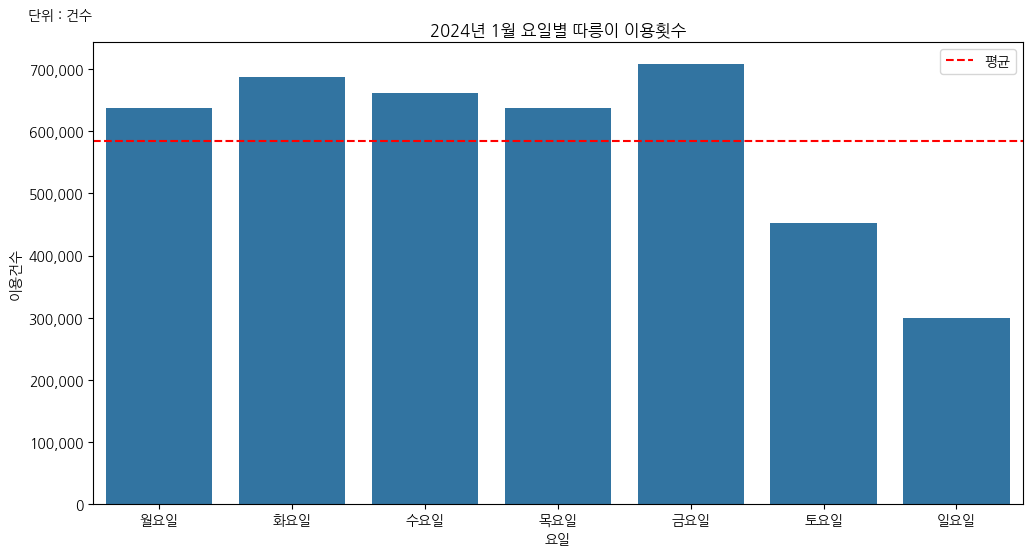

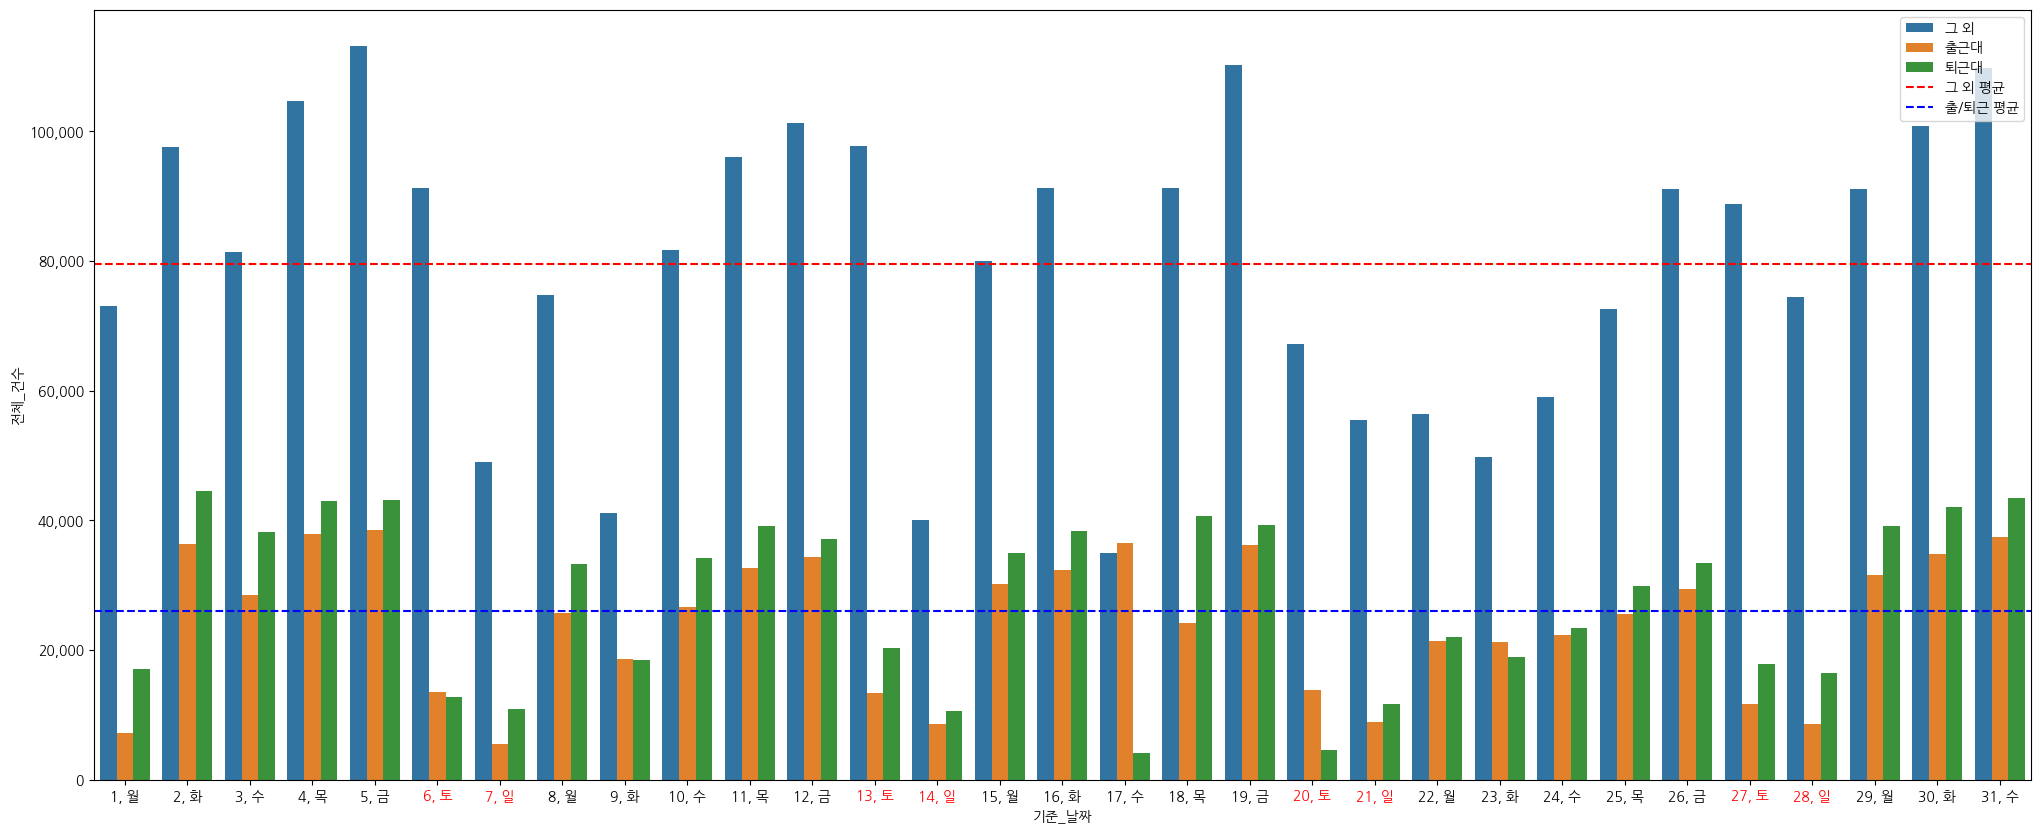

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd


total_data = pd.read_csv('total_data01.csv', parse_dates=['일시'])
##1. 요일별 따릉이 이용횟수 확인하기
# 요일 컬럼 추가
total_data['요일'] = total_data['일시'].dt.dayofweek
# 요일별 이용건수 그룹화
dayofweek_use = total_data.groupby(['요일'], as_index=False)['이용건수'].sum()
# 숫자로된 요일을 str 변환하기 위한 dict 생성
day_map = {
    0: '월요일',
    1: '화요일',
    2: '수요일',
    3: '목요일',
    4: '금요일',
    5: '토요일',
    6: '일요일'
}
# map() 메서드를 활용한 요일(숫자 코드) => 요일(str) 변환
dayofweek_use['요일'] = dayofweek_use['요일'].map(day_map)

##1-1. 요일별 따릉이 이용건수 시각화
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='요일', y='이용건수', data = dayofweek_use)
plt.title('2024년 1월 요일별 따릉이 이용횟수')
# y축 범례 자릿수 표기(,)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# y축 범례 단위 '건' 표기 넣고, 위치를 y축 밖 상단 중앙에 놓기
ax.text(-0.07, 1.05, '단위 : 건수', rotation=0, transform=ax.transAxes)

# 이용건수 평균 선 그리기
ax.axhline(y=dayofweek_use['이용건수'].mean(), color='r', linestyle='--', label='평균')
ax.legend()

#######################################################################################################
##2. 일별, 시간대별 따릉이 이용건수

df = pd.read_csv('ddareungi01.csv', encoding='utf-8', parse_dates=['기준_날짜'])
## 시간의 계산을 위한 '기준_시간대', '전체_이용_분' 컬럼의 datatype 변환
## 'HH(시간)MM(분)'형태 int type의 '기준_시간대'컬럼을 datetime type으로 변환
df['기준_시간대'] = df['기준_시간대'].astype('str').str.pad(4,'left','0')
df['기준_시간대'] = pd.to_datetime(df['기준_시간대'], format='%H%M')

## 'MM(분)'형태 int type의 '기준_시간대'컬럼을 datetime type으로 변환
df['전체_이용_분'] = df['전체_이용_분']*60
df['전체_이용_분'] = pd.to_datetime(df['전체_이용_분'], unit='s', origin='1900-01-01')

## 집계_기준 => 출발, 도착 두 가지 ==> 출발기준 통일
## [출발시간 기준]기준_시간대 = [도착시간 기준]기준_시간대 - 전체_이용_분
df.query('집계_기준 == "도착시간"')['기준_시간대'] = df.query('집계_기준 == "도착시간"')['기준_시간대'] - df.query('집계_기준 == "도착시간"')['전체_이용_분']
## '기준_시간대' 컬럼의 값들을 dt.time으로 시간:분:초 형태로 변경
df['기준_시간대'] = df['기준_시간대'].dt.time
## func (사용자정의 함수)로 '시간대' 컬럼 생성 '기준_시간대' 값의 범주화 : 다음 셀에 func 정의
df['시간대'] = df['기준_시간대'].map(func)

df2 = df.groupby(['기준_날짜','시간대'], as_index=False)['전체_건수'].sum()

##2-2. 일별, 시간대별 따릉이 이용건수 시각화하기
plt.figure(figsize=(25,10))
ax2 = sns.barplot(data=df2, x='기준_날짜', y='전체_건수', hue='시간대')

# y축 범례 자릿수 표기(,)
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# x축 눈금 표기 설정
label_day = pd.Series(df2['기준_날짜'].unique()) ## unique() 메서드는 datetime.narray를 반환 하므로 Series로 변환
ax2.set_xticks(label_day.index)
day_week = ((label_day.dt.dayofweek).map(day_map)).str.replace('요일','') ## 눈금 라벨 길이를 생각해서 '요일' 단어 삭제
xlabel = (label_day.dt.day).astype('str') + ', ' + day_week ## X축 눈금에 요일 추가
ax2.set_xticklabels(xlabel, rotation=0); ## X축 설정

# X축 눈금 중 주말(토, 일)에 해당하는 눈금 label 색상을 'red'로 설정
for i, label in  enumerate(ax2.get_xticklabels()):
  if label.get_text().split(' ')[1] in ['토','일'] :
    label.set_color('red')

##
mean1 = df2.query('시간대=="그 외"')['전체_건수'].mean()
mean2 = df2.query('시간대.isin(["출근대","퇴근대"])')['전체_건수'].mean()
ax2.axhline(y=mean1, color='r', linestyle='--', label='그 외 평균')
ax2.axhline(y=mean2, color='b', linestyle='--', label='출/퇴근 평균')

# 범례 위치 지정
ax2.legend(loc='upper right')

#### 해석

In [ ]:
## 1-1. 그래프 : 요일별 총 따릉이 이용 건수
# 해석 : 주말 이용건수는 평일 이용건수는 물론 평균 이용자 수보다 적다.
# 추정 가설 : 평일은 출퇴근 용도 사용 때문에 주말보다 평균 이용자 수가 많을 것이다.
#### -> 요일별 시간대별 이용자 수 분석으로 검증

## 2-1. 그래프 : 일자별(요일별) 시간대별 총 따릉이 이용 건수
# 해석 : 평일 출퇴근 시간대 이용자 수는 주말 동일 시간대 보다 많고, 대부분 평균에 근사하거나 많다.
# 또한, 주말의 출퇴근 시간대 외 따릉이 이용자 수는 평일과 크게 다르지 않다.
# 일자별 기상 현황(날씨)를 고려한 분석으로 당위성 확보가 필요

## 2024년 2월 따릉이 데이터 분석

- 2월 요일별 따릉이사용횟수 분석

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   요일      7 non-null      object
 1   이용건수    7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 244.0+ bytes


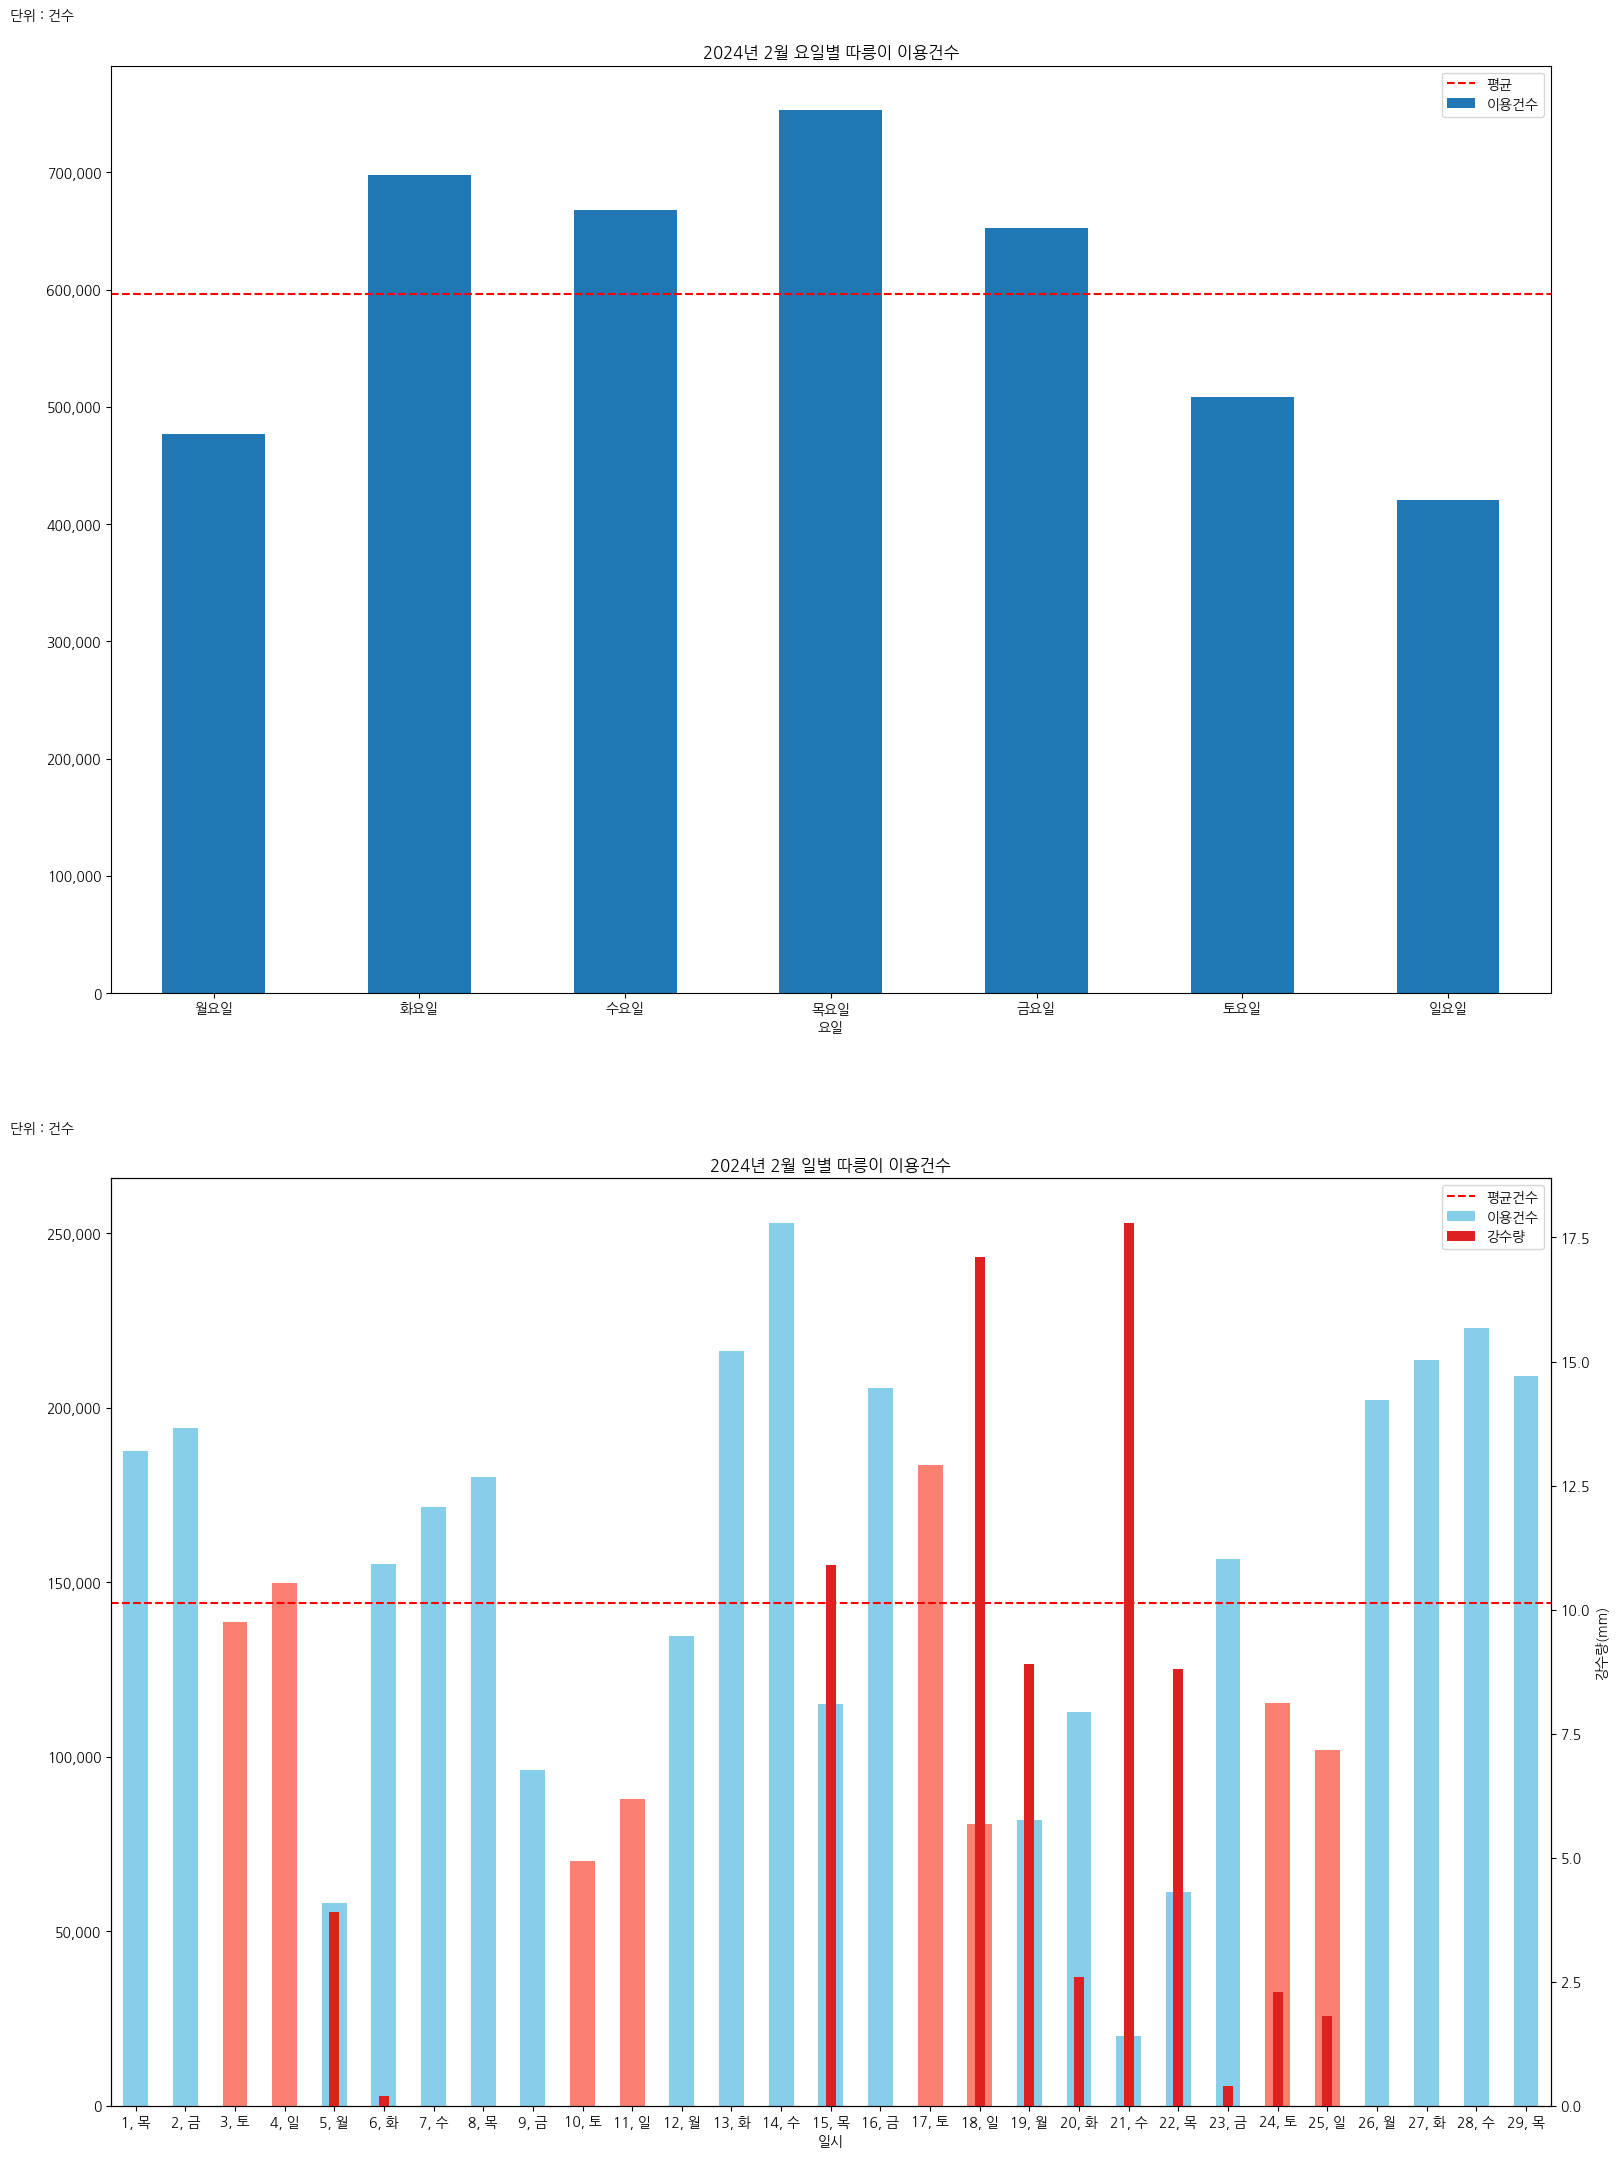

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

# 2024년 2월 따릉이 데이터 가져오기
ddareungi02 = pd.read_csv('ddareungi02.csv', encoding='utf-8', parse_dates=['기준_날짜'])
ddareungi02.rename(columns={'기준_날짜':'일시', '전체_건수':'이용건수'}, inplace=True)
# 요일 컬럼 추가
ddareungi02.insert(loc = 1, column='요일', value=ddareungi02['일시'].dt.dayofweek)
# ddareungi02.to_pickle('ddareungi02.pkl')


# 2024년 2월 요일 따릉이 이용건수
use_ddareungi02 = ddareungi02.groupby(['요일'], as_index=False)['이용건수'].sum()
day_map = {
    0: '월요일',
    1: '화요일',
    2: '수요일',
    3: '목요일',
    4: '금요일',
    5: '토요일',
    6: '일요일'
}
use_ddareungi02['요일'] = use_ddareungi02['요일'].map(day_map)
use_ddareungi02.info()
use_ddareungi02.head()

## figure 및 axes 생성
fig, ax = plt.subplots(2,1, figsize=(16, 30))
## axes간 수직 패딩 조절
# fig.tight_layout(rect=(0, 0, 0, 0.2))
plt.subplots_adjust(0,0.2)

##1. 2월 요일별 따릉이 이용건수 시각화
use_ddareungi02.plot( x='요일', y='이용건수', kind='bar', ax=ax[0])

# 제목 설정
ax[0].set_title('2024년 2월 요일별 따릉이 이용건수')
# y축 눈금 자릿수 표기(,)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# y축 눈금 단위 '건' 표기 넣고, 위치를 y축 밖 상단 중앙에 놓기
ax[0].text(-0.07, 1.05, '단위 : 건수', rotation=0, transform=ax[0].transAxes)
# x축 눈금 라벨 설정
xlabel = use_ddareungi02['요일']
ax[0].set_xticklabels(xlabel, rotation=0)

# 이용건수 평균 선 그리기
ax[0].axhline(y=use_ddareungi02['이용건수'].mean(), color='r', linestyle='--', label='평균')
ax[0].legend()


##2. 2024년 2월 일별 따릉이 이용건수 시각화
day_use_ddareungi02 = ddareungi02.groupby(['일시'], as_index=False)['이용건수'].sum()
## bar컬러 리스트 생성 ==> 토요일, 일요일 'salmon' 색, 평일 'skyblue'로 표현
colors = ['salmon' if day in [5, 6] else 'skyblue' for day in (day_use_ddareungi02['일시'].dt.dayofweek)]
day_use_ddareungi02.plot( x='일시', y='이용건수', kind='bar', ax=ax[1], color=colors)

# 제목 설정
ax[1].set_title('2024년 2월 일별 따릉이 이용건수')
# y축 눈금 자릿수 표기(,)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# y축 눈금 단위 '건' 표기 넣고, 위치를 y축 밖 상단 중앙에 놓기
ax[1].text(-0.07, 1.05, '단위 : 건수', rotation=0, transform=ax[1].transAxes)
# x축 눈금 라벨 설정
### 요일을 나타내는 series 생성
x = ddareungi02.groupby(['일시','요일'], as_index=False)['이용건수'].sum()
day_week = x['요일'].map(day_map).str.replace('요일','') ## 눈금 길이를 생각해서 '요일' 단어 삭제
### x축 눈금 라벨 입력을 위한 '일자, 요일' 형태의 변수 생성
xlabel = (day_use_ddareungi02['일시'].dt.day).astype('str') + ', ' + day_week
ax[1].set_xticklabels(xlabel, rotation=0);

# 이용건수 평균 선 그리기
ax[1].axhline(y=day_use_ddareungi02['이용건수'].mean(), color='r', linestyle='--', label='평균건수')


##2-1. 2월 일별 강수량을 ax[1]에 같이 시각화
# 2024년 2월 날씨 데이터 가져오기
weather = pd.read_csv('weather.csv', encoding='utf-8', parse_dates=['일시'])
weather_02 = weather.query('일시 >= "2024-02-01" and 일시 < "2024-03-01"' )
weather_02[['일시','강수량(mm)']]

# 2024년 2월 강수량 시각화
ax2 = ax[1].twinx()
sns.barplot(x = weather_02['일시'] , y = weather_02['강수량(mm)'], width=0.2, color='r', label='강수량', legend=False)

## 범례 합치기
# 각 Axes의 핸들과 레이블 가져오기
handles1, labels1 = ax[1].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# 결합
handles = handles1 + handles2
labels = labels1 + labels2
# 범례 생성
ax[1].legend(handles, labels, loc='upper right')

### 해석

In [ ]:
## 1. 첫 번째 2월 요일별 따릉이 이용건수 그래프
# 1월과 마찬가지로 평일에 비해 주말 이용 건수가 적고, 평균 이용 건수에 미치지 못한다.
# 다만 2월의 월요일 이용 건수 또한 평균에 미치지 못한다.
# 추정가설 : 2월의 월요일에는 휴일이 있거나, 날씨의 영향으로 이용건수가 적을 것이다.
# ==> 그래프.2에서 보이듯 월요일 (5일, 19일에는 우천으로 이용 건수가 적다)

## 2. 일자/요일별 따릉이 이용 건수 및 강수량 그래프
# 평일 비가 오는 날(빨강색 강수량 표시가 있는 날)은 따릉이 이용 횟수가 평균보다 적다.
# 9일(금), 12일(월)만 평일 중 비가 오지 않았지만 평균 이용 건수보다 적다.
# 추정가설 : 다른 날씨 요인, 또는 공휴일, 휴가 등이 많았을 것이다. ==> 해당 월은 겨울이므로 날씨 요인(강설)을 생각해 볼 수 있음
# 또한, 강수량이 많지 않다면 시간대별 우천상황이 아닐 시 따릉이를 이용했을 것이다.

In [ ]:
# 2월 날씨 데이터, 따릉이 일별 따릉이 이용건수 데이터 병합
total_data02 = pd.merge(day_use_ddareungi02, weather_02, on='일시', how='inner')
# total_data02.to_csv('total_data02.csv', encoding='utf-8', index=False)

pandas.core.series.Series

# 기상요소별 따릉이사용횟수 분석

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


total_data01 = pd.read_csv('total_data01.csv', parse_dates=['일시'])

In [242]:
total_data

,일시,이용건수,지점번호,지점명,평균기온(℃),최고기온(℃),최고기온시각,최저기온(℃),최저기온시각,평균습도(%rh),최저습도(%rh),평균풍속(m/s),최대풍속(m/s),최대풍속풍향(deg),최대풍속시각,최대순간풍속(m/s),최대순간풍속풍향(deg),최대순간풍속시각,강수량(mm),요일
0,2024-01-01,97200,108,서울,3.3,7.3,12:55,-0.3,4:02,83.4,65,1.7,3.2,180.0,15:25,4.5,180.0,15:18,0.0,0
1,2024-01-02,178406,108,서울,2.9,4.3,14:09,2.2,6:22,72.6,59,1.6,3.1,270.0,14:09,5.3,250.0,14:07,0.0,1
2,2024-01-03,148106,108,서울,1.8,4.0,13:20,-1.1,23:50,80.4,72,1.6,4.2,320.0,14:35,7.6,320.0,14:33,0.6,2
3,2024-01-04,185758,108,서울,1.4,4.7,15:56,-3.3,7:15,74.3,64,1.9,3.4,50.0,11:05,6.1,180.0,17:52,0.0,3
4,2024-01-05,194836,108,서울,5.0,9.1,14:39,1.4,23:56,77.1,59,2.3,4.8,250.0,12:53,10.3,180.0,14:23,0.0,4
5,2024-01-06,117688,108,서울,0.7,5.2,14:44,-2.7,8:19,63.9,34,2.2,4.0,250.0,15:04,7.7,320.0,18:22,2.4,5
6,2024-01-07,65446,108,서울,-4.4,-0.9,0:01,-8.3,23:12,57.4,34,3.1,6.9,290.0,13:10,11.7,290.0,12:56,0.0,6
7,2024-01-08,133836,108,서울,-4.7,0.0,14:41,-10.3,6:19,57.8,29,1.8,4.0,320.0,1:07,5.7,340.0,0:58,0.0,0
8,2024-01-09,78224,108,서울,-0.6,0.4,22:39,-1.9,0:01,84.0,62,2.0,3.0,50.0,9:37,4.6,50.0,5:48,1.6,1
9,2024-01-10,142594,108,서울,-1.0,3.3,15:42,-4.1,6:32,85.9,69,1.7,3.0,290.0,13:22,4.7,290.0,13:28,0.0,2


#Seaborn 깨짐 방지

In [ ]:
# -----------------------------------------------------
# 1. 나눔 폰트 설치 (Colab 환경에 따라 시간이 좀 걸릴 수 있습니다.)
# -----------------------------------------------------
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv # 폰트 캐시 갱신
!rm ~/.cache/matplotlib -rf # Matplotlib 캐시 삭제 (필수)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,554 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and dire

폰트 설정 완료! 이제 한글이 제대로 표시될 것입니다.


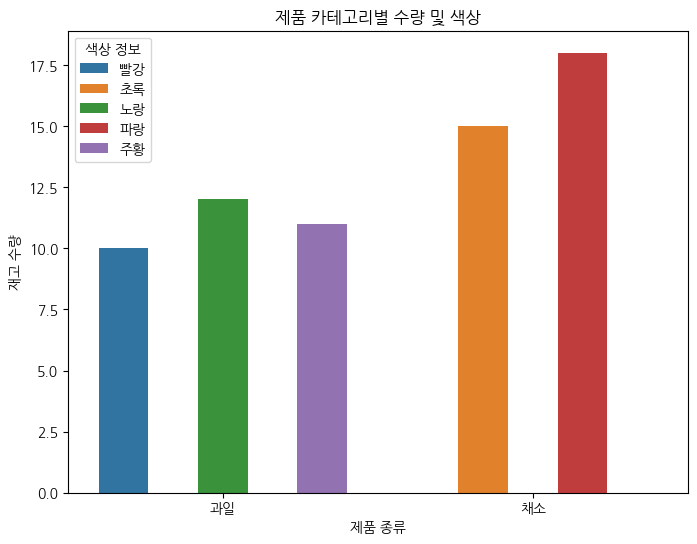

In [ ]:

# -----------------------------------------------------
# 2. 런타임 다시 시작 (매우 중요!)
# -----------------------------------------------------
# 위에 폰트 설치 코드를 실행한 후, 반드시 런타임을 다시 시작해야 합니다.
# 런타임 > 런타임 다시 시작 (Ctrl + M)

# -----------------------------------------------------
# 3. Matplotlib 폰트 설정 (런타임 재시작 후 이 셀부터 다시 실행)
# -----------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 나눔고딕 폰트 설정
plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("폰트 설정 완료! 이제 한글이 제대로 표시될 것입니다.")

# -----------------------------------------------------
# 4. 예시 데이터 및 그래프 (한글 확인)
# -----------------------------------------------------
data = {
    '카테고리': ['과일', '채소', '과일', '채소', '과일'],
    '수량': [10, 15, 12, 18, 11],
    '색상': ['빨강', '초록', '노랑', '파랑', '주황']
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.barplot(x='카테고리', y='수량', hue='색상', data=df)
plt.title('제품 카테고리별 수량 및 색상')
plt.xlabel('제품 종류')
plt.ylabel('재고 수량')
plt.legend(title='색상 정보')
plt.show()